#**PROBLEMA DE NEGOCIO**


---




##Una empresa de telecomunicaciones desea mejorar la retención de sus clientes, identificando aquellos que tienen más chances de abandonar el servicio (Churn). Como científico de datos, tu objetivo será limpiar y preparar un conjunto de datos para el entrenamiento de un modelo de Churn. A continuación, se presentan las preguntas clave que guiarán el proceso de limpieza de datos:

### **Preguntas**

1. ¿Qué insights podemos obtener del análisis exploratorio inicial del conjunto de datos?

2. ¿Qué transformaciones básicas son necesarias para preparar los datos?

3. ¿Cómo podemos identificar y tratar los datos duplicados y los valores nulos?

4. ¿Cómo manejamos los outliers presentes en el dataset?

5. ¿Qué técnicas aplicamos para procesar las variables categóricas?

#**1. Configuración del Ambiente**


---




In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
global datos_churn

#**2. Obtención y Tratamiento de Datos**


---




##**2.1 Cargando las bases de datos**

In [2]:
datos_churn = pd.read_json("base_clientes.json")
datos_churn.head()

,id_cliente,Churn,cliente,telefono,internet,cuenta
0,0002-ORFBO,no,"{'genero': 'femenino', 'anciano': 0, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': None, 'facturacion_electronica': ..."
1,0003-MKNFE,no,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': 'mensual', 'facturacion_electroni..."
2,0004-TLHLJ,si,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
3,0011-IGKFF,si,"{'genero': 'masculino', 'anciano': 1, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
4,0013-EXCHZ,si,"{'genero': 'femenino', 'anciano': 1, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."


In [3]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  7344 non-null   object
 1   Churn       7344 non-null   object
 2   cliente     7344 non-null   object
 3   telefono    7344 non-null   object
 4   internet    7344 non-null   object
 5   cuenta      7344 non-null   object
dtypes: object(6)
memory usage: 344.4+ KB


In [4]:
def lectura_datos():
  global datos_churn
  with open("base_clientes.json") as f:
    json_bruto = json.load(f)
  datos_churn = pd.json_normalize(json_bruto)
  return datos_churn

In [5]:
lectura_datos()
datos_churn.head()

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0002-ORFBO,no,femenino,0,si,si,9.0,si,no,DSL,no,si,no,si,si,no,None,None,None,NaN,None
1,0003-MKNFE,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.9,542.4
2,0004-TLHLJ,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.9,280.85
3,0011-IGKFF,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.0,1237.85
4,0013-EXCHZ,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.9,267.4


##**2.2 Tratamiento de datos**

In [6]:
with open('/content/Diccionario.txt', 'r', encoding='utf-8') as file:
    contenido = file.read()
print(contenido)

La base de datos contiene columnas además del ID de los clientes y el churn:

Cliente:
género: género (masculino y femenino)
anciano: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
pareja: si el cliente tiene o no una pareja
dependientes: si el cliente tiene o no dependientes
tiempo_servicio: meses de contrato del cliente

Servicio de telefonía:
servicio_telefono: suscripción al servicio telefónico
varias_lineas: suscripción a más de una línea telefónica

Servicio de internet:
servicio_internet: suscripción a un proveedor de internet
seguridad_online: suscripción adicional a seguridad en línea
backup_online: suscripción adicional a copias de seguridad en línea
proteccion_dispositivo: suscripción adicional a protección en el dispositivo
soporte_tecnico: suscripción adicional a soporte técnico, menos tiempo de espera
tv_streaming: suscripción a TV por cable
peliculas_streaming: suscripción a streaming de películas

Cuenta:
contrato: tipo de contrato
factura_e

In [7]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7344 non-null   object 
 1   Churn                            7344 non-null   object 
 2   cliente.genero                   7344 non-null   object 
 3   cliente.anciano                  7344 non-null   int64  
 4   cliente.pareja                   7344 non-null   object 
 5   cliente.dependientes             7344 non-null   object 
 6   cliente.tiempo_servicio          7336 non-null   float64
 7   telefono.servicio_telefono       7344 non-null   object 
 8   telefono.varias_lineas           7344 non-null   object 
 9   internet.servicio_internet       7344 non-null   object 
 10  internet.seguridad_online        7344 non-null   object 
 11  internet.backup_online           7344 non-null   object 
 12  internet.proteccion_

In [8]:
datos_churn.head(5)

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0002-ORFBO,no,femenino,0,si,si,9.0,si,no,DSL,no,si,no,si,si,no,None,None,None,NaN,None
1,0003-MKNFE,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.9,542.4
2,0004-TLHLJ,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.9,280.85
3,0011-IGKFF,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.0,1237.85
4,0013-EXCHZ,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.9,267.4


In [9]:
# Analizando valores nulos.

## .isnull() obtenemos los nulo, con el .any nos devuelve un serie booleana, donde True significa que en ese registro
## tenemos valores nulos y False, que no tenemos.
nulos = datos_churn.isnull().any(axis=1)

## Hallamos los indices de los registros donde tenemos nulos
indices_nulos = datos_churn[nulos].index

## Filtramos nuestros datos para obtene un dataframe filtrado, con los nulos, esto para analizar mejor la situación
df_filtro_nulo = datos_churn.loc[indices_nulos]

## Buscamos la cantidad de nulos por variable, de esta forma, nos devuelve una serie booleana
## donde el indice son los nombres de las variables y el valor que nos devuelve es un conteo
## de nulos por variable
df_filtro_nulo.isnull().sum()

,0
id_cliente,0
Churn,0
cliente.genero,0
cliente.anciano,0
cliente.pareja,0
cliente.dependientes,0
cliente.tiempo_servicio,8
telefono.servicio_telefono,0
telefono.varias_lineas,0
internet.servicio_internet,0


Obersamos que tenemos nulos en:

1. cuenta.contrato: 32 nulos
2. cuenta.facturacion_electronica: 18 nulos
3. cuenta.metodo_pago: 27 nulos
4. cuenta.cobros.mensual: 18 nulos
5. cuenta.cobros.Total: 16 nulos

Aunque no son muchos nulos procederemos a evaluar como tratarlos, primero nos centraremos en las columnas de cuenta.

In [10]:
columnas = ["cliente.tiempo_servicio","cuenta.contrato","cuenta.cobros.mensual","cuenta.cobros.Total"]
# Filtrando por columnas
df_filtro_nulo[columnas]

,cliente.tiempo_servicio,cuenta.contrato,cuenta.cobros.mensual,cuenta.cobros.Total
0,9.0,None,NaN,None
9,NaN,dos años,90.45,5957.9
181,NaN,mensual,29.30,355.9
186,NaN,mensual,63.95,318.1
452,67.0,None,NaN,6886.25
773,NaN,dos años,101.05,5971.25
994,21.0,None,NaN,1565.7
1645,18.0,None,20.05,None
1646,23.0,None,NaN,None
1647,55.0,None,NaN,None


</p aling = "justify">Si tomamos cliente.tiempo_servicio y cuenta.cobros.mensual	y multiplicamos ambos, tenemos un valor que se acerca al monto total, en algunos casos, sin embargo, este valor difiere con el monto total por algunas cifras, esto quiere decir que hay un costo que se suma o resta, dependiendo de otra variable, por lo cual no podemos llenar los valores faltantes del monto total de esta forma. Ahora observaremos si tenemos valores faltantes o dicho de otra vacios en cada variable: </p>

In [11]:
# Filtro para valores vacios
valores_vacios = datos_churn == ""

# Filtrando
cantidad_vacios_por_columna = valores_vacios.sum()
cantidad_vacios_por_columna

,0
id_cliente,0
Churn,226
cliente.genero,0
cliente.anciano,0
cliente.pareja,0
cliente.dependientes,0
cliente.tiempo_servicio,0
telefono.servicio_telefono,0
telefono.varias_lineas,0
internet.servicio_internet,0


</p aling = "Justify">Observamos que tenemos 226 valores vacios en la feature target churn, y ahora en el preprocesamiento primero la llenaremos con un NaN, y procederemos a eliminarla estos nuevos nulos con el resto de nulos del dataframe al mismo tiempo</p>

Observando outlier en cliente.tiempo_servicio

<Axes: ylabel='cliente.tiempo_servicio'>

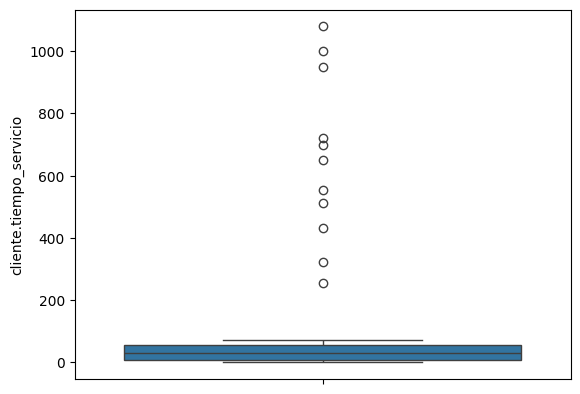

In [12]:
sns.boxplot(datos_churn["cliente.tiempo_servicio"])

Obervamos que tenemos valores muy altos, algunos superan los 1000 meses, es decir más de 80 años. Es poco probable encontrar personas con estos tiempos de serivicios tan altos, para este caso trataremos con estos datos usando el rango intercuartílico con el fin de obtener mejores soluciones.

In [13]:
# Primer cuartil
q1 = datos_churn["cliente.tiempo_servicio"].quantile(0.25)

# 3re cuartil
q3 = datos_churn["cliente.tiempo_servicio"].quantile(0.75)

# Rango intercuatilico
IQR = q3 - q1
# Limite superior
limite_superior = q3 + 1.5 * IQR
# Limite inferior
limite_inferior = q1 - 1.5 * IQR

# Filtrar con los nuevos limites la data
datos_outlier = datos_churn[(datos_churn["cliente.tiempo_servicio"] < limite_inferior ) | (datos_churn["cliente.tiempo_servicio"] > limite_superior)]
datos_outlier

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
2001,2830-LEWOA,no,masculino,0,si,si,1080.0,si,no,fibra optica,no,si,si,si,si,si,un año,no,tarjeta de credito (automatico),103.90,112212.0
2002,2831-EBWRN,no,masculino,0,no,no,1000.0,si,no,DSL,no,no,no,no,no,no,mensual,si,cheque electronico,45.90,45900.0
2008,2834-SPCJV,si,masculino,0,si,no,950.0,si,no,fibra optica,si,no,no,no,si,no,mensual,no,cheque electronico,84.10,79895.0
2012,2842-JTCCU,si,masculino,0,no,no,254.0,si,no,DSL,no,no,no,no,no,no,mensual,no,transferencia bancaria (automatica),46.05,80.35
2014,2845-AFFTX,si,masculino,1,si,no,321.0,si,si,fibra optica,no,no,si,no,si,si,mensual,si,cheque electronico,99.80,4259.3
2019,2851-STERV,no,masculino,1,no,no,650.0,si,no,DSL,no,no,si,si,si,si,un año,si,cheque electronico,73.00,47450.0
2021,2855-QOWGP,,masculino,0,no,si,700.0,si,si,fibra optica,si,si,no,no,si,si,un año,si,cheque electronico,103.80,3470.8
2023,2856-NNASM,si,masculino,1,no,no,721.0,si,no,fibra optica,no,no,no,no,si,si,mensual,si,cheque,89.55,3856.75
2027,2862-JVEOY,no,masculino,0,no,no,555.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,un año,no,cheque,19.15,124.4
2030,2865-TCHJW,si,femenino,1,no,no,433.0,si,si,fibra optica,no,no,si,no,si,no,mensual,si,cheque electronico,89.20,346.2


Observamos que nuestros valores outliers, son los que se encuentran por el limite superarior, nada por debajo del limite, pero entre estos datos encontramos que tenemos cantidad de meses entre 200 y 512, lo cual indica 45 años de servicio este ultimo, aunque es mucho, puede haber clientes con esa cantidad de años usando el servicio, sin embargo los eliminaremos ya que puede llegar a afectar al modelo predictivo.

In [14]:
datos_churn = datos_churn[(datos_churn["cliente.tiempo_servicio"] >= limite_inferior) & (datos_churn["cliente.tiempo_servicio"] <= limite_superior)]
datos_churn.reset_index(drop=True, inplace=True)

<Axes: ylabel='cliente.tiempo_servicio'>

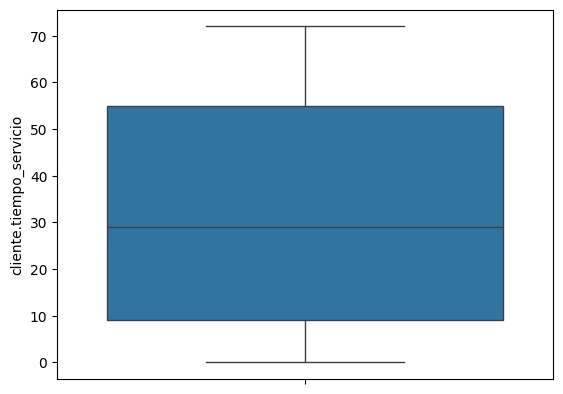

In [15]:
sns.boxplot(datos_churn["cliente.tiempo_servicio"])

Parece que nuestros datos estan dentro de valores razonables, por tanto, nos quedaremos con los datos con esta forma.

Ahora si porcedamos a eliminar nulos, duplicados, y realizar el resto del tratamiento de los datos.

In [16]:
def preprocesamiento():
  global datos_churn
  ## Todos los datos vacios en churn lo rellenaremos con NaN
  columnas_object = datos_churn.select_dtypes(include = "object").columns
  datos_churn[columnas_object]  = datos_churn[columnas_object].replace(' ',np.nan)
  datos_churn[columnas_object]  = datos_churn[columnas_object].replace('',np.nan)
  ## Eliminando registros nulos
  datos_churn.dropna(inplace = True)
  ## Eliminando registros nulos
  datos_churn.drop_duplicates(inplace=True)
  ## Conversión de columnas según su tipo de dato correspondiente
  datos_churn["cliente.tiempo_servicio"] = datos_churn["cliente.tiempo_servicio"].astype(int) # A Int
  datos_churn["cuenta.cobros.Total"] = datos_churn["cuenta.cobros.Total"].astype(float)
  datos_churn.reset_index(drop=True, inplace=True)
  return datos_churn

In [17]:
preprocesamiento()
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       6977 non-null   object 
 1   Churn                            6977 non-null   object 
 2   cliente.genero                   6977 non-null   object 
 3   cliente.anciano                  6977 non-null   int64  
 4   cliente.pareja                   6977 non-null   object 
 5   cliente.dependientes             6977 non-null   object 
 6   cliente.tiempo_servicio          6977 non-null   int64  
 7   telefono.servicio_telefono       6977 non-null   object 
 8   telefono.varias_lineas           6977 non-null   object 
 9   internet.servicio_internet       6977 non-null   object 
 10  internet.seguridad_online        6977 non-null   object 
 11  internet.backup_online           6977 non-null   object 
 12  internet.proteccion_

##**2.3 Normalizacion de datos**

In [18]:
for col in datos_churn.columns:
    print(f"Columna: {col}")
    print(datos_churn[col].unique())
    print("-" * 30)

Columna: id_cliente
['0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Columna: Churn
['no' 'si']
------------------------------
Columna: cliente.genero
['masculino' 'femenino']
------------------------------
Columna: cliente.anciano
[0 1]
------------------------------
Columna: cliente.pareja
['no' 'si']
------------------------------
Columna: cliente.dependientes
['no' 'si']
------------------------------
Columna: cliente.tiempo_servicio
[ 9  4 13  3 71 63  7 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67 20
 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21 61
 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 65 51 38 42]
------------------------------
Columna: telefono.servicio_telefono
['si' 'no']
------------------------------
Columna: telefono.varias_lineas
['si' 'no' 'sin servicio de telefono']
------------------------------
Columna: internet.servicio_internet
['DSL' 'fibra optica' '

</p align="justify"> Eliminaremos algunas columnas primeramente, determinaremos las menos relevantes y luego procederemos a realizar el encodeo de las variables categóricas según los datos que tenemos en cada varaible </p>

In [19]:
def normalizacion():
  global datos_churn
  # Supongamos que tu DataFrame se llama df
  # Lista de columnas de servicios de internet
  servicios_internet = [
      'internet.servicio_internet',
      'internet.seguridad_online',
      'internet.backup_online',
      'internet.proteccion_dispositivo',
      'internet.soporte_tecnico',
      'internet.tv_streaming',
      'internet.peliculas_streaming'
  ]

  # Crear una nueva columna para contar los servicios
  datos_churn['total_servicios_internet'] = 0

  # Iterar sobre cada fila del DataFrame
  for index, row in datos_churn.iterrows():
      count = 0
      # Iterar sobre cada columna de servicios
      for servicio in servicios_internet:
          if row[servicio] == 'si':
              count += 1
      # Asignar el conteo a la nueva columna
      datos_churn.at[index, 'total_servicios_internet'] = count

  #
  datos_churn.drop("id_cliente", axis = 1, inplace = True)
  datos_churn.reset_index(drop=True, inplace=True)
  diccionario_map = {"no":0,
                     "si": 1,
                     "masculino": 0,
                     "femenino": 1}
  columnas_tratamiento_binario = ["telefono.servicio_telefono",
                          "Churn",
                          "cliente.pareja",
                          "cliente.dependientes",
                          "cuenta.facturacion_electronica",
                          "cliente.genero"]
  datos_churn[columnas_tratamiento_binario] = datos_churn[columnas_tratamiento_binario].replace(diccionario_map)
  ## Cambiar de tipo de variable
  datos_churn["Churn"] = datos_churn["Churn"].astype(int)  # A int
  datos_churn.reset_index(drop=True, inplace=True)
  ## Para las variables "telefono.varias_lineas" "internet.servicio_internet" "internet.seguridad_online"
  ## "internet.backup_online" "internet.proteccion_dispositivo" "internet.soporte_tecnico" "internet.tv_streaming" "internet.peliculas_streaming" "cuenta.contrato"
  columnas_tratamiento = ["telefono.varias_lineas",
                          "internet.servicio_internet",
                          "internet.seguridad_online",
                          "internet.backup_online",
                          "internet.proteccion_dispositivo",
                          "internet.soporte_tecnico",
                          "internet.tv_streaming",
                          "internet.peliculas_streaming",
                          'cuenta.metodo_pago']
  datos_churn  = pd.get_dummies(datos_churn, columns = columnas_tratamiento, drop_first = True, dtype = int)
  ## Usando OrdinalEncoder de scikit-learn
  encoder = OrdinalEncoder(categories=[['mensual', 'un año', 'dos años']])
  datos_churn['cuenta.contrato_ordinal_sklearn'] = encoder.fit_transform(datos_churn[['cuenta.contrato']])
  datos_churn['cuenta.contrato_ordinal_sklearn'] = datos_churn['cuenta.contrato_ordinal_sklearn'].astype(int)
  datos_churn.drop("cuenta.contrato", axis = 1, inplace = True)
  datos_churn.reset_index(drop=True, inplace=True)


  ## Nueva variables agregadas
  datos_churn['ratio_gasto_tiempo'] = datos_churn['cuenta.cobros.Total'] / datos_churn['cliente.tiempo_servicio']
  # Calcula el gasto total adicional
  datos_churn['gasto_total_adicional'] = datos_churn['cuenta.cobros.Total'] - (datos_churn['cuenta.cobros.mensual'] * datos_churn['cliente.tiempo_servicio'])

  # Crea las columnas 'gasto_adicional' y 'descuento_promociones'
  datos_churn['gasto_adicional'] = datos_churn['gasto_total_adicional'].apply(lambda x: x if x > 0 else 0)
  datos_churn['descuento_promociones'] = datos_churn['gasto_total_adicional'].apply(lambda x: abs(x) if x < 0 else 0)

  # Elimina la columna 'gasto_total_adicional' si ya no es necesaria
  datos_churn.drop(columns=['gasto_total_adicional'], inplace=True)

  return

In [20]:
normalizacion()
datos_churn.head()

<ipython-input-19-75130fa38a96>:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos_churn[columnas_tratamiento_binario] = datos_churn[columnas_tratamiento_binario].replace(diccionario_map)


,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,cuenta.facturacion_electronica,cuenta.cobros.mensual,cuenta.cobros.Total,total_servicios_internet,telefono.varias_lineas_si,telefono.varias_lineas_sin servicio de telefono,internet.servicio_internet_fibra optica,internet.servicio_internet_no,internet.seguridad_online_si,internet.seguridad_online_sin servicio de internet,internet.backup_online_si,internet.backup_online_sin servicio de internet,internet.proteccion_dispositivo_si,internet.proteccion_dispositivo_sin servicio de internet,internet.soporte_tecnico_si,internet.soporte_tecnico_sin servicio de internet,internet.tv_streaming_si,internet.tv_streaming_sin servicio de internet,internet.peliculas_streaming_si,internet.peliculas_streaming_sin servicio de internet,cuenta.metodo_pago_cheque electronico,cuenta.metodo_pago_tarjeta de credito (automatico),cuenta.metodo_pago_transferencia bancaria (automatica),cuenta.contrato_ordinal_sklearn,ratio_gasto_tiempo,gasto_adicional,descuento_promociones
0,0,0,0,0,0,9,1,0,59.9,542.40,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,60.266667,3.3,0.00
1,1,0,0,0,0,4,1,1,73.9,280.85,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,70.212500,0.0,14.75
2,1,0,1,1,0,13,1,1,98.0,1237.85,4,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,95.219231,0.0,36.15
3,1,1,1,1,0,3,1,1,83.9,267.40,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,89.133333,15.7,0.00
4,0,1,0,0,1,9,1,1,69.4,571.45,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,63.494444,0.0,53.15


In [21]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 34 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Churn                                                     6977 non-null   int64  
 1   cliente.genero                                            6977 non-null   int64  
 2   cliente.anciano                                           6977 non-null   int64  
 3   cliente.pareja                                            6977 non-null   int64  
 4   cliente.dependientes                                      6977 non-null   int64  
 5   cliente.tiempo_servicio                                   6977 non-null   int64  
 6   telefono.servicio_telefono                                6977 non-null   int64  
 7   cuenta.facturacion_electronica                            6977 non-null   int64  
 8   cuenta.cobros.mens

#**3. Modelo Random Forest**


---


In [22]:
y = datos_churn['Churn']
x = datos_churn.drop(columns='Churn')
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state = 50)

In [23]:
def pronosticar(train_x, train_y):
  model = RandomForestClassifier(random_state=50)
  model.fit(train_x, train_y)
  return model

In [24]:
model = pronosticar(train_x, train_y)
model.score(test_x, test_y)

0.7889207258834766

In [25]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6977 entries, 0 to 6976
Data columns (total 34 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Churn                                                     6977 non-null   int64  
 1   cliente.genero                                            6977 non-null   int64  
 2   cliente.anciano                                           6977 non-null   int64  
 3   cliente.pareja                                            6977 non-null   int64  
 4   cliente.dependientes                                      6977 non-null   int64  
 5   cliente.tiempo_servicio                                   6977 non-null   int64  
 6   telefono.servicio_telefono                                6977 non-null   int64  
 7   cuenta.facturacion_electronica                            6977 non-null   int64  
 8   cuenta.cobros.mens

#**4. Reducción de Dimensionalidad**


---


##**4.1 Métodos Gráficos**

In [26]:
#def diagrama_violin(df, inicio, fin):


def diagrama_puntos(df, inicio, fin):
    df = df.drop(['ratio_gasto_tiempo','gasto_adicional','cuenta.cobros.Total',"cuenta.cobros.mensual"],axis = 1)
    df = df[df.select_dtypes(include = "int").columns]
    y = df["Churn"]
    x = df.drop(columns = "Churn")
    df = pd.concat([y, x.iloc[:,1:30]], axis = 1)
    df_melted = pd.melt(df, id_vars = "Churn", var_name = "features", value_name = "valores")
    #df_melted = df_melted.groupby(['Churn', 'features'])['valores'].value_counts(normalize=True).unstack().fillna(0).stack().reset_index(name='proporciones')
    plt.figure(figsize= (12, 6))
    sns.pointplot(x = "features", y = "valores", hue = "Churn", data = df_melted)
    plt.ylim(df_melted['valores'].min(), df_melted['valores'].max())
    plt.title('Comparación de variables por Churn')
    plt.xticks(rotation=90)
    plt.show()

def mapa_calor(df):
    grafico = df.corr()
    plt.figure( figsize = (17,15))
    sns.heatmap(grafico, annot = True, fmt = ".1f")
    return grafico

In [27]:
datos_churn.head()

,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,cuenta.facturacion_electronica,cuenta.cobros.mensual,cuenta.cobros.Total,total_servicios_internet,telefono.varias_lineas_si,telefono.varias_lineas_sin servicio de telefono,internet.servicio_internet_fibra optica,internet.servicio_internet_no,internet.seguridad_online_si,internet.seguridad_online_sin servicio de internet,internet.backup_online_si,internet.backup_online_sin servicio de internet,internet.proteccion_dispositivo_si,internet.proteccion_dispositivo_sin servicio de internet,internet.soporte_tecnico_si,internet.soporte_tecnico_sin servicio de internet,internet.tv_streaming_si,internet.tv_streaming_sin servicio de internet,internet.peliculas_streaming_si,internet.peliculas_streaming_sin servicio de internet,cuenta.metodo_pago_cheque electronico,cuenta.metodo_pago_tarjeta de credito (automatico),cuenta.metodo_pago_transferencia bancaria (automatica),cuenta.contrato_ordinal_sklearn,ratio_gasto_tiempo,gasto_adicional,descuento_promociones
0,0,0,0,0,0,9,1,0,59.9,542.40,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,60.266667,3.3,0.00
1,1,0,0,0,0,4,1,1,73.9,280.85,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,70.212500,0.0,14.75
2,1,0,1,1,0,13,1,1,98.0,1237.85,4,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,95.219231,0.0,36.15
3,1,1,1,1,0,3,1,1,83.9,267.40,2,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,89.133333,15.7,0.00
4,0,1,0,0,1,9,1,1,69.4,571.45,3,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,63.494444,0.0,53.15


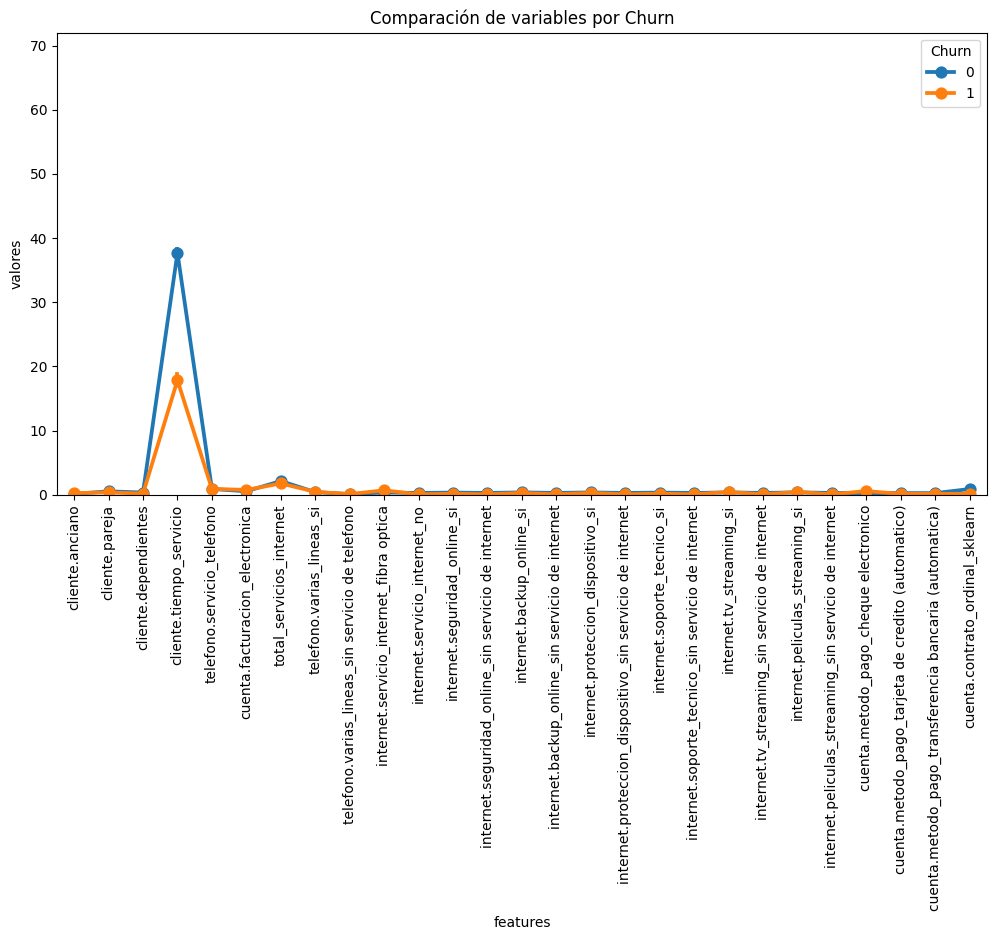

In [28]:
diagrama_puntos(datos_churn, 1, 30)

In [29]:
datos_churn.groupby('Churn')["telefono.varias_lineas_sin servicio de telefono"].value_counts(normalize=True)

Churn  telefono.varias_lineas_sin servicio de telefono
0      0                                                  0.901092
       1                                                  0.098908
1      0                                                  0.909238
       1                                                  0.090762
Name: proportion, dtype: float64

In [30]:
train_x = train_x.drop(columns=["telefono.varias_lineas_sin servicio de telefono"])
test_x = test_x.drop(columns=["telefono.varias_lineas_sin servicio de telefono"])
model = pronosticar(train_x, train_y)
model.score(test_x, test_y)

0.7951289398280802

##**4.2 Mapa de Calor**

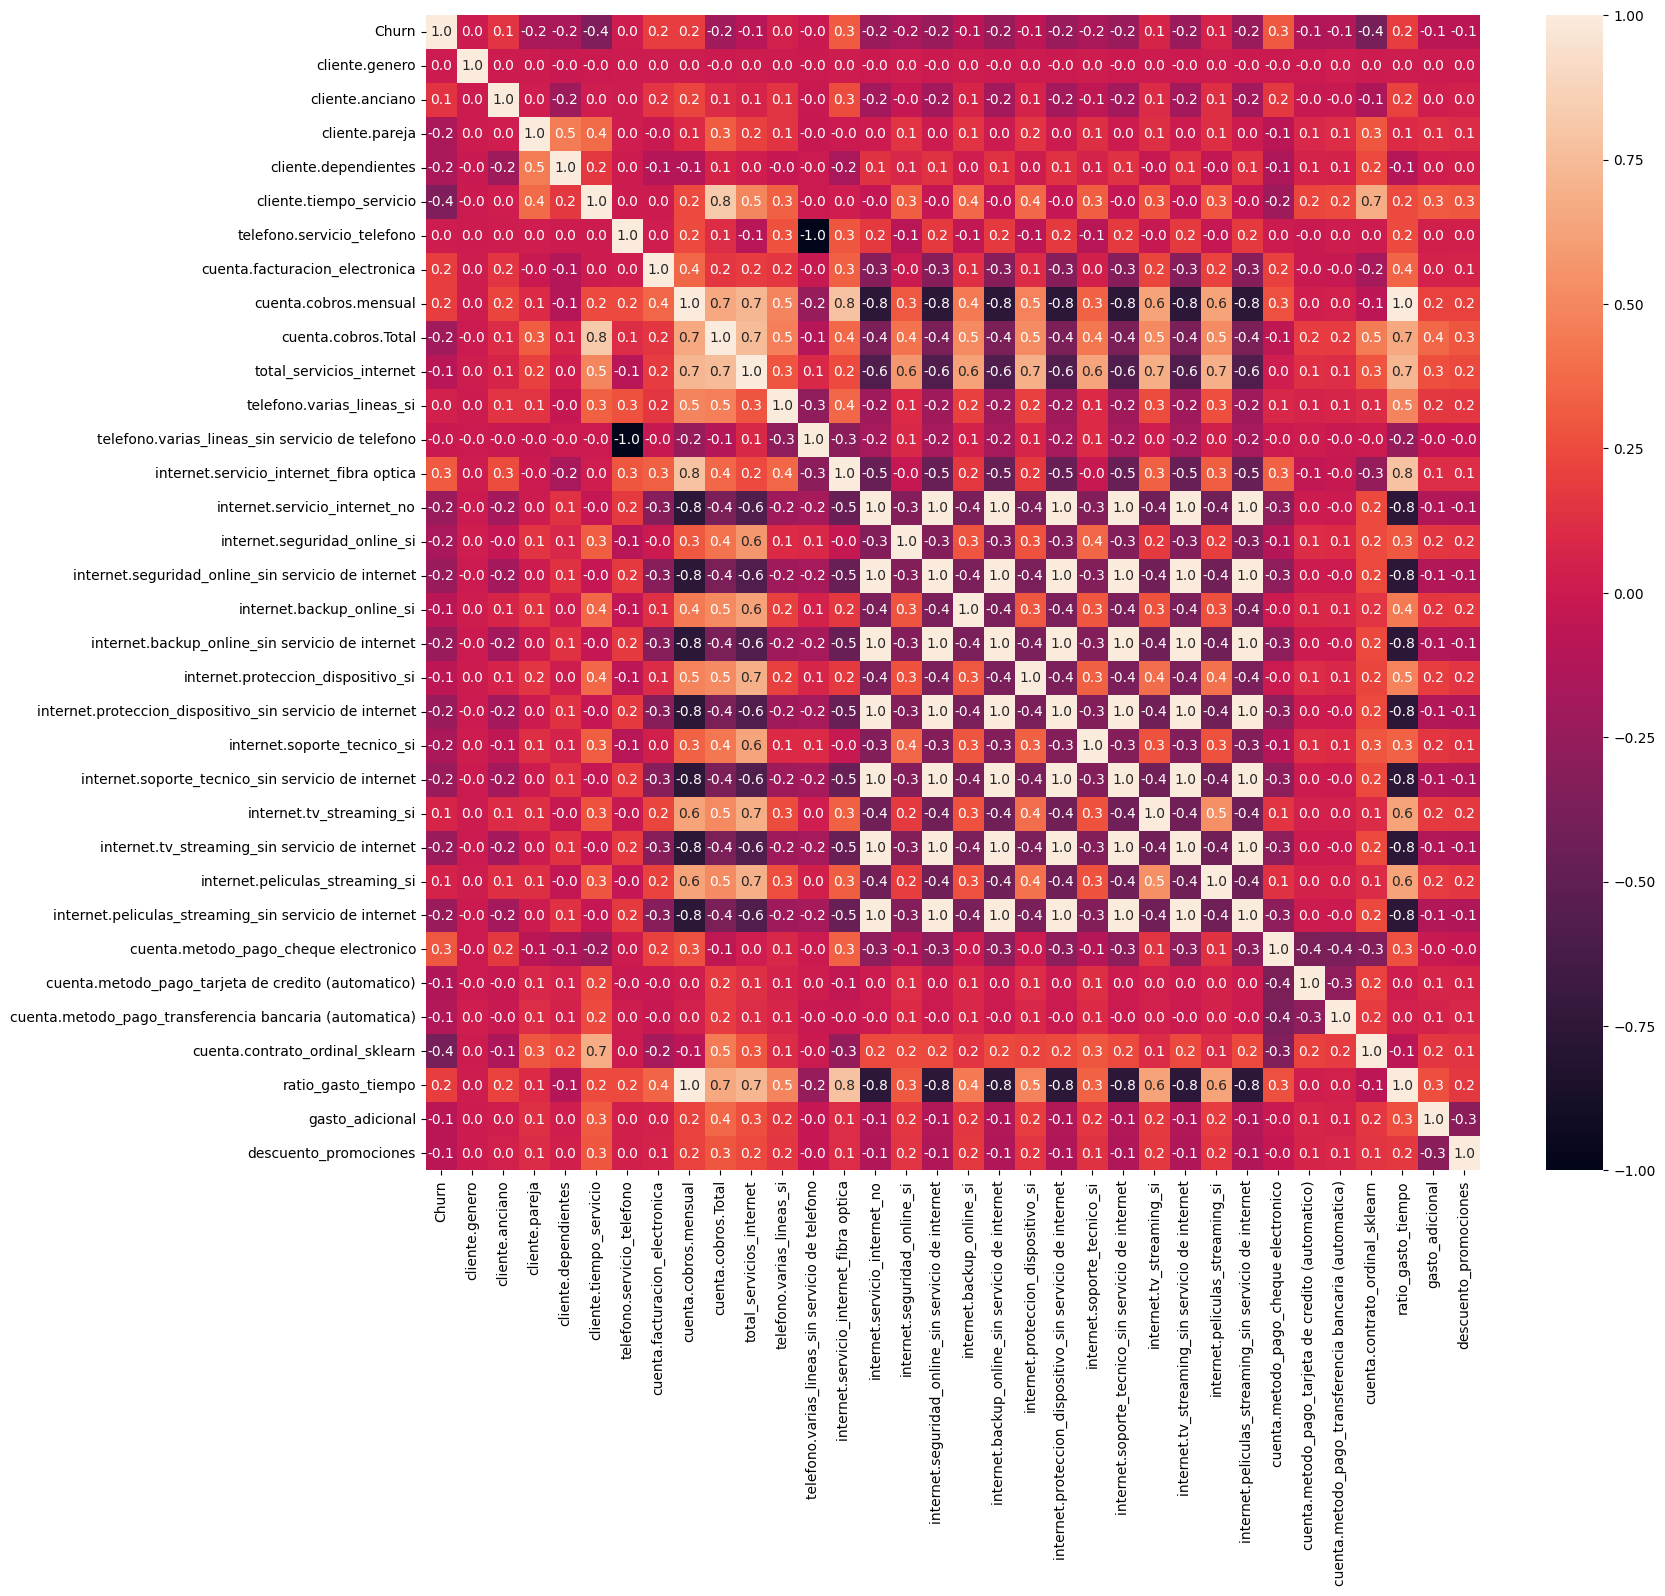

In [31]:
matriz = mapa_calor(datos_churn)

In [32]:
matriz2 = matriz>0.99
matriz2 = matriz2.sum()
matriz2[matriz2>1]

,0
cuenta.cobros.mensual,2
internet.servicio_internet_no,7
internet.seguridad_online_sin servicio de internet,7
internet.backup_online_sin servicio de internet,7
internet.proteccion_dispositivo_sin servicio de internet,7
internet.soporte_tecnico_sin servicio de internet,7
internet.tv_streaming_sin servicio de internet,7
internet.peliculas_streaming_sin servicio de internet,7
ratio_gasto_tiempo,2


In [33]:
def identificar_variables(base):
    variables_a_eliminar = []

    for variable in base.index:
        if base[variable] > 1:
            variables_a_eliminar.append(variable)
    return variables_a_eliminar

In [34]:
identificar_variables(matriz2[matriz2>1])

['cuenta.cobros.mensual',
 'internet.servicio_internet_no',
 'internet.seguridad_online_sin servicio de internet',
 'internet.backup_online_sin servicio de internet',
 'internet.proteccion_dispositivo_sin servicio de internet',
 'internet.soporte_tecnico_sin servicio de internet',
 'internet.tv_streaming_sin servicio de internet',
 'internet.peliculas_streaming_sin servicio de internet',
 'ratio_gasto_tiempo']

In [35]:
train_x = train_x.drop(columns=['ratio_gasto_tiempo',
                                'internet.seguridad_online_sin servicio de internet',
                                'internet.backup_online_sin servicio de internet',
                                'internet.proteccion_dispositivo_sin servicio de internet',
                                'internet.soporte_tecnico_sin servicio de internet',
                                'internet.tv_streaming_sin servicio de internet',
                                'internet.peliculas_streaming_sin servicio de internet'])
test_x = test_x.drop(columns=['ratio_gasto_tiempo',
                              'internet.seguridad_online_sin servicio de internet',
                              'internet.backup_online_sin servicio de internet',
                              'internet.proteccion_dispositivo_sin servicio de internet',
                              'internet.soporte_tecnico_sin servicio de internet',
                              'internet.tv_streaming_sin servicio de internet',
                              'internet.peliculas_streaming_sin servicio de internet'])
model = pronosticar(train_x, train_y)
model.score(test_x, test_y)

0.8008595988538681

##**4.3 Feature Importances**

In [36]:
def pronosticar_kbest(train_x, test_x, train_y, test_y):
    selector = SelectKBest(score_func=chi2, k=10)
    train_x_selected = selector.fit_transform(train_x, train_y)
    test_x_selected = selector.transform(test_x)

    model = RandomForestClassifier()
    model.fit(train_x_selected, train_y)
    test_score = model.score(test_x_selected, test_y)

    print(f"Accuracy en prueba con SelectKBest y chi2: {test_score}")


In [37]:
pronosticar_kbest(train_x, test_x, train_y, test_y)

Accuracy en prueba con SelectKBest y chi2: 0.774116523400191


In [38]:
def pronosticar_RFE(train_x, test_x, train_y, test_y):
    model = RandomForestClassifier()
    selector = RFE(estimator = model, n_features_to_select = 10, step = 1)
    train_x_selected = selector.fit_transform(train_x, train_y)
    test_x_selected = selector.transform(test_x)
    model.fit(train_x_selected, train_y)
    test_score = model.score(test_x_selected, test_y)
    print(f"Accuracy en prueba con RFE: {test_score}")

In [39]:
pronosticar_RFE(train_x, test_x, train_y, test_y)

Accuracy en prueba con RFE: 0.7827125119388729


In [40]:
def pronosticar_PCA(train_x, test_x, train_y, test_y):
    pca = PCA(n_components = 10)
    train_x_pca = pca.fit_transform(train_x)
    test_x_pca = pca.transform(test_x)
    model = RandomForestClassifier()
    model.fit(train_x_pca, train_y)
    test_score = model.score(test_x_pca, test_y)
    print(f"Accuracy en prueba con RFE: {test_score}")

In [41]:
pronosticar_PCA(train_x, test_x, train_y, test_y)

Accuracy en prueba con RFE: 0.7946513849092646
